# **ResNet**



**Get github files**

In [1]:
!git clone https://github.com/a-martyn/resnet.git

Cloning into 'resnet'...
remote: Enumerating objects: 283, done.
remote: Total 283 (delta 0), reused 0 (delta 0), pack-reused 283
Receiving objects: 100% (283/283), 54.51 MiB | 37.14 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
cd resnet

/content/resnet


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## **Imports**

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
# from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [5]:
# GLOBALS
# -----------------------

data_dir = 'data/cifar10'
batch_size = 128


##**Load Data functions**

In [6]:
def get_data_loaders(data_dir,
                     batch_size,
                     train_transform,
                     test_transform,
                     shuffle=True,
                     num_workers=4,
                     pin_memory=False):
    """
    Adapted from: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
    
    Utility function for loading and returning train and test
    multi-process iterators over the CIFAR-10 dataset.
    If using CUDA, set pin_memory to True.
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - train_transform: pytorch transforms for the training set
    - test_transform: pytorch transofrms for the test set
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    
    Returns
    -------
    - train_loader: training set iterator.
    - test_loader:  test set iterator.
    """
    
    #****************************************************************
    valid_size = 0.10
    random_seed = 42
    

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=test_transform,
    )

    num_train = len(train_dataset) #20000
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # TODO shuffle instead of sampler?
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    #****************************************************************
    
    # # Create loader objects
    # train_loader = torch.utils.data.DataLoader(
    #     train_dataset, batch_size=batch_size, shuffle=shuffle,
    #     num_workers=num_workers, pin_memory=pin_memory
    # )

    # test_loader = torch.utils.data.DataLoader(
    #     test_dataset, batch_size=batch_size, shuffle=shuffle,
    #     num_workers=num_workers, pin_memory=pin_memory
    # )
          
    return (train_loader, valid_loader)


def plot_images(images, cls_true, cls_pred=None):
    """
    Plot images with labels.
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    
    # CIFAR10 labels
    label_names = [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ]
    
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


## **Data augmentation: Training set**


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


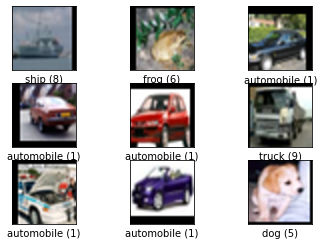

torch.Size([128, 3, 32, 32])


In [7]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

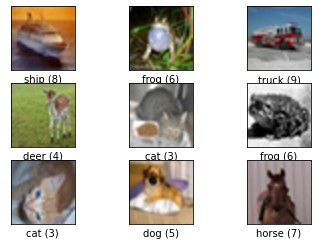

torch.Size([128, 3, 32, 32])


In [8]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [ ]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Takes a while to run so I've hardcoded results below

means, stds = calculate_normalisation_params(train_loader, test_loader)
print(f'means: {means}')
print(f'stds: {stds}')

Files already downloaded and verified
Files already downloaded and verified


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [ ]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [ ]:
# TRAINING PARAMETERS
# -------------------------

# number of trails
runs = 1 # 4

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 100
#10 # 164

# OPTIMISER PARAMETERS
lr = 0.1 
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 9]



### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [ ]:
# TRAIN PLAIN NETs

for n in ns:
    print(f'MODEL SIZE: n={n}')
    for i in range(runs):
      print(f'#Run={i}')
      # Reload data
      train_loader, test_loader = get_data_loaders(data_dir,
                                                  batch_size,
                                                  train_transform,
                                                  test_transform,
                                                  shuffle=True,
                                                  num_workers=4,
                                                  pin_memory=True)
      
      model = ResNet(n, shortcuts=False)
      criterion = torch.nn.NLLLoss()
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
      scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
      results_file = f'results/plainnet{6*n+2}run{i}.csv'
      model_file = f'pretrained/plainnet{6*n+2}run{i}.pt'
      train(model, epochs, train_loader, test_loader, criterion, 
            optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [ ]:
# TRAIN RESNETs

for n in ns:
    print(f'MODEL SIZE: n={n}')
    for i in range(runs):
          print(f'#Run={i}')
          # Reload data
          train_loader, test_loader = get_data_loaders(data_dir,
                                                      batch_size,
                                                      train_transform,
                                                      test_transform,
                                                      shuffle=True,
                                                      num_workers=4,
                                                      pin_memory=True)
          
          model = ResNet(n, shortcuts=True)
          criterion = torch.nn.NLLLoss()
          optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
          scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
          results_file = f'results/resnet{6*n+2}run{i}.csv'
          model_file = f'pretrained/resnet{6*n+2}run{i}.pt'
          train(model, epochs, train_loader, test_loader, criterion, 
                optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [ ]:
# print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}') 

The PyTorch model architecture for a 20 layer model.

In [ ]:
# print(model)

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

In [ ]:
ns  = [3, 9]
color = ['y', 'r']


plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, epochs, 0, 100])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{color[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{color[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Plain-20, VS Plain-56')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
plt.show()

In [ ]:
plainnet20_dfs = [pd.read_csv(f'results/plainnet{6*3+2}run{i}.csv') for i in range(runs)]
plainnet56_dfs = [pd.read_csv(f'results/plainnet{6*9+2}run{i}.csv') for i in range(runs)]

concat_20_table = pd.concat(plainnet20_dfs)
concat_56_table = pd.concat(plainnet56_dfs)

cols = [j for j in range(epochs)]
statistic20_df = pd.DataFrame(columns=cols, index=['mean', 'std'])
statistic56_df = pd.DataFrame(columns=cols, index=['mean', 'std'])

statistic20_df.loc['mean'] = concat_20_table.groupby('epoch')['test_err'].mean()*100
statistic20_df.loc['std'] = concat_20_table.groupby('epoch')['test_err'].std()

statistic56_df.loc['mean'] = concat_56_table.groupby('epoch')['test_err'].mean()*100
statistic56_df.loc['std'] = concat_56_table.groupby('epoch')['test_err'].std()

x = list(range(epochs))
x_rev = x[::-1]

# Line 1: plain-20 test error
y1 = list(statistic20_df.loc['mean'])
y1_upper = list(y1 + statistic20_df.loc['std'])
y1_lower = list(y1 - statistic20_df.loc['std'])
y1_lower = y1_lower[::-1]

# Line 2: plain-56 test error
y2 = list(statistic56_df.loc['mean'])
y2_upper = list(y2 + statistic56_df.loc['std'])
y2_lower = list(y2 - statistic56_df.loc['std'])
y2_lower = y2_lower[::-1]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='plain-20 test err',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y2_upper+y2_lower,
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
    name='plain-56 test err',
    showlegend=False,
))

fig.add_trace(go.Scatter(
    x=x, y=y1,
    line_color='rgb(0,100,80)',
    name='plain-20 test err',
))
fig.add_trace(go.Scatter(
    x=x, y=y2,
    line_color='rgb(0,176,246)',
    name='plain-56 test err',
))

fig.update_traces(mode='lines')
fig.update_layout(title={'text': "Plain-20 VS Plain-56",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'} , xaxis_title="Epochs",
    yaxis_title="Error (%)",template='plotly_dark')
fig.show()
fig.write_html("plain_errors.html")

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet56']
display(bests_df[['model', 'test_err']])


### Resnet

In [ ]:
ns  = [3, 9]
clr = ['y', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, epochs, 0, 100])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('ResNet-20 VS ResNet-56.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
resnet20_dfs = [pd.read_csv(f'results/resnet{6*3+2}run{i}.csv') for i in range(runs)]
resnet56_dfs = [pd.read_csv(f'results/resnet{6*9+2}run{i}.csv') for i in range(runs)]

concat_20_table = pd.concat(resnet20_dfs)
concat_56_table = pd.concat(resnet56_dfs)

cols = [j for j in range(epochs)]
statistic20_df = pd.DataFrame(columns=cols, index=['mean', 'std'])
statistic56_df = pd.DataFrame(columns=cols, index=['mean', 'std'])

statistic20_df.loc['mean'] = concat_20_table.groupby('epoch')['test_err'].mean()*100
statistic20_df.loc['std'] = concat_20_table.groupby('epoch')['test_err'].std()*100

statistic56_df.loc['mean'] = concat_56_table.groupby('epoch')['test_err'].mean()*100
statistic56_df.loc['std'] = concat_56_table.groupby('epoch')['test_err'].std()*100

x = list(range(epochs))
x_rev = x[::-1]

# Line 1: plain-20 test error
y1 = list(statistic20_df.loc['mean'])
y1_upper = list(y1 + statistic20_df.loc['std'])
y1_lower = list(y1 - statistic20_df.loc['std'])
y1_lower = y1_lower[::-1]

# Line 2: plain-56 test error
y2 = list(statistic56_df.loc['mean'])
y2_upper = list(y2 + statistic56_df.loc['std'])
y2_lower = list(y2 - statistic56_df.loc['std'])
y2_lower = y2_lower[::-1]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='resnet-20 test err',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y2_upper+y2_lower,
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
    name='resnet-56 test err',
    showlegend=False,
))

fig.add_trace(go.Scatter(
    x=x, y=y1,
    line_color='rgb(0,100,80)',
    name='resnet-20 test err',
))
fig.add_trace(go.Scatter(
    x=x, y=y2,
    line_color='rgb(0,176,246)',
    name='resnet-56 test err',
))

fig.update_traces(mode='lines')
fig.update_layout(title={'text': "ResNet-20 VS ResNet-56",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'} , xaxis_title="Epochs",
    yaxis_title="Error (%)",template='plotly_dark')
fig.show()
fig.write_html("resnet_errors.html")

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])


## Side-by-side plot

In [ ]:
ns  = [3, 9]
clr = ['y', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 164, 0, 20])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')